In [99]:
import os
import re
import time
import gensim.downloader as api
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl

import emot 
import emoji

from autocorrect import Speller
import re

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


In [100]:
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pl.read_csv(path + "/" + filename)
        li.append(df)
    output = pl.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

match_test=pl.read_csv("../challenge_data/train_tweets/AustraliaNetherlands29.csv")
match_test.head()

ID,MatchID,PeriodID,EventType,Timestamp,Tweet
str,i64,i64,i64,i64,str
"""12_0""",12,0,0,1403106600000,"""RT @FIFAWorldCup: #AUS LINE-UP…"
"""12_0""",12,0,0,1403106600000,"""“@WSJSports: #USA soccer's Cli…"
"""12_0""",12,0,0,1403106600000,"""#persieing in his sleep! #AUS …"
"""12_0""",12,0,0,1403106600000,"""Glad I got my tune in radio to…"
"""12_0""",12,0,0,1403106600000,"""INSTAGRAM: Are you following t…"


In [101]:

timsetamps=match_test["Timestamp"]
distinct_timestamps=timsetamps.unique()
period_id=match_test["PeriodID"]
distinct_period_ids=period_id.unique()
print(len(distinct_period_ids))
print(len(distinct_timestamps))
print(len(distinct_timestamps)/len(distinct_period_ids))
timestamp_differenceces=np.diff(distinct_timestamps)
print(timestamp_differenceces)

print(len(period_id))

97
5806
59.855670103092784
[1000 1000 1000 ... 1000 1000 1000]
96834


In [ ]:
def add_time_sec(df):
    ''' remplace la  colonne timestamp par une colonne avec la seconde du match'''
    # Récupération de la première valeur de "Timestamp"
    first_timestamp = df["Timestamp"][0]
 
    seconds = (df["Timestamp"] - first_timestamp) // 1000

    df = df.with_columns([seconds.alias("Seconds")])

    df.drop_in_place("Timestamp")
    
    return df


match_seconds=add_time_sec(match_test)

seconds=match_seconds["Seconds"]
distinct_seconds=seconds.unique()
print(len(distinct_seconds))
print(distinct_seconds)

5806
shape: (5_806,)
Series: 'Seconds' [i64]
[
	0
	1
	2
	3
	4
	…
	5801
	5802
	5803
	5804
	5805
]


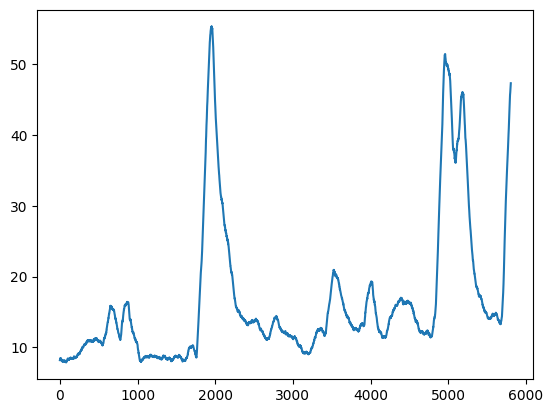

In [ ]:
import polars as pl

import polars as pl

def frequence_fenetre(df, previous_sec, following_sec):
    """
    Calcul de la fréquence moyenne des tweets par fenêtre de temps.

    Args:
    df : DataFrame Polars contenant une colonne "Seconds".
    previous_sec : Nombre de secondes en arrière pour la fenêtre.
    following_sec : Nombre de secondes en avant pour la fenêtre.

    Returns:
    DataFrame Polars avec une colonne supplémentaire "Frequency".
    """
    # Étape 1 : Compter les occurrences de chaque seconde
    counts = (
        df.group_by(["Seconds"])  # Utilisation de `group_by` spécifique à votre version
        .agg(pl.count("Seconds").alias("tweet_count"))
    )
    
    # Étape 2 : Créer un dictionnaire des comptes pour un accès rapide
    tweet_count_dict = dict(zip(counts["Seconds"].to_list(), counts["tweet_count"].to_list()))

    # Étape 3 : Calculer la fréquence pour chaque ligne
    frequencies = []
    for sec in df["Seconds"].to_list():
        # Liste des secondes dans la fenêtre
        neighbors = range(sec - previous_sec, sec + following_sec + 1)
        # Nombre de secondes valides (effectivement présentes dans le dictionnaire)
        valid_seconds = [neighbor for neighbor in neighbors if neighbor in tweet_count_dict]
        num_valid_seconds = len(valid_seconds)
        # Calculer la somme des tweets dans la fenêtre et diviser par le nombre de secondes valides
        freq = sum(tweet_count_dict.get(neighbor, 0) for neighbor in valid_seconds)
        average_freq = freq / num_valid_seconds if num_valid_seconds > 0 else 0
        frequencies.append(average_freq)
    
    # Étape 4 : Ajouter la colonne "Frequency" au DataFrame
    df = df.with_columns(pl.Series("Frequency", frequencies))
    
    return df


match_freq = frequence_fenetre(match_seconds, 50, h0)
match_freq.head()
seconds=match_freq["Seconds"]
frequency=match_freq["Frequency"]
plt.plot(seconds,frequency)

0.7855195489187682


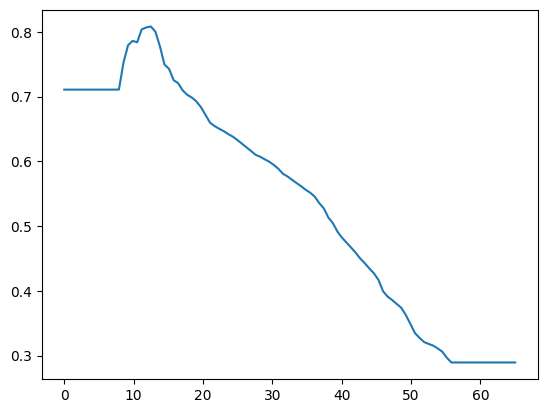

In [104]:
def classif_freq(df, seuil):
    """
    Classification des tweets en fonction de leur fréquence.

    Args:
    df : DataFrame Polars contenant une colonne "Frequency".
    seuil : Seuil de fréquence pour la classification.

    Returns:
    DataFrame Polars avec une colonne supplémentaire "Class".
    """
    # Création de la colonne "Class" à partir de la colonne "Frequency"
    df = df.with_columns([pl.Series("Class", (df["Frequency"] > seuil).to_list())])
    nb_correct = (df["Class"] == df["EventType"]).sum()
    nb_total = df.shape[0]
    return nb_correct/nb_total

print(classif_freq(match_freq, 10))
seuils=np.linspace(0,65,100)
accuracies=[classif_freq(match_freq, seuil) for seuil in seuils]
plt.plot(seuils,accuracies)

Nombre total de tweets par intervalle : [10916, 15387, 15874, 11711, 4549, 3280, 1469, 1969, 1552, 1936, 1667, 2132, 3576, 3345, 2827, 3683, 2491, 4171, 1654, 2585]
Nombre de tweets classifiés par intervalle : [0.1781788200806156, 0.42568401897705854, 0.6829406576792239, 0.6678336606609171, 0.7518135854033854, 0.9542682926829268, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


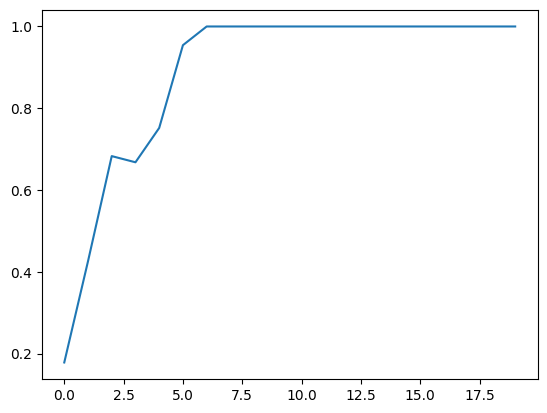

In [105]:
import numpy as np
import polars as pl

# Définir les intervalles de fréquence
max_freq=match_freq["Frequency"].max()
min_freq=match_freq["Frequency"].min()
n_bins=20
intervals = [(min_freq + i * (max_freq - min_freq) / n_bins, min_freq + (i + 1) * (max_freq - min_freq) / n_bins) for i in range(n_bins)]


# Initialiser les vecteurs pour stocker les résultats
tweets_per_interval = []
classified_tweets_per_interval = []

# Parcourir les intervalles pour effectuer le calcul
for lower, upper in intervals:
    # Filtrer les tweets dans l'intervalle de fréquence
    tweets_in_interval = match_freq.filter((pl.col("Frequency") >= lower) & (pl.col("Frequency") < upper))
    
    # Nombre total de tweets dans cet intervalle
    total_tweets = tweets_in_interval.height
    tweets_per_interval.append(total_tweets)
    
    # Nombre de tweets classifiés (Class == 1) dans cet intervalle
    classified_tweets = tweets_in_interval.filter(pl.col("EventType") == 1).height/total_tweets
    classified_tweets_per_interval.append(classified_tweets)

# Afficher les résultats
print("Nombre total de tweets par intervalle :", tweets_per_interval)
print("Nombre de tweets classifiés par intervalle :", classified_tweets_per_interval)

# plt.hist(match_freq["Frequency"], bins=n_bins, color="skyblue", edgecolor="black")
# plt.xlabel("Fréquence")
# plt.ylabel("Nombre de tweets")
# plt.show()

plt.plot(classified_tweets_per_interval)


In [106]:
print(pl.__version__)

1.16.0
